# Weight and Attention-Map Visualizations

### Setup:

**Imports, Paths, GPU-Settings and Flags:**

In [8]:
import os
import jax
import pickle as pkl
import jax.numpy as jnp
from flax.training import train_state
from typing import Dict, List
from matplotlib import pyplot as plt, colors
from matplotlib.colors import TwoSlopeNorm

from configs.config import get_experiment_config, get_model_config
from src.training_init import TrainingInitializer

In [36]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
devices = jax.devices()

rerun_models = False
rerun_analyses = False
store_results = False

path_model_fully_7 = 'experiment_results/linear_seq_fully/model_sm_7l_fullfledged.pkl'
path_model_fully_3 = 'experiment_results/linear_seq_fully/model_sm_3l_fullfledged.pkl'
path_model_partobs_7 = 'experiment_results/linear_seq_partial/model_sm_7l_fullfledged.pkl'
path_model_nonlin_7 = 'experiment_results/nonlinear_seq_fully/model_sm_7l_fullfledged.pkl'
path_model_fully_mesa = 'experiment_results/linear_seq_fully/model_mesa_fullfledged.pkl'

models_full = {'full_seven_sm': 'fully_obs_full_fledged_transformer.6.4.40.50.20.True.False.False.False.0.False.False.0.False.False.False.False',
               'full_seven_lin': 'fully_obs_full_fledged_transformer.6.4.40.50.20.True.False.False.False.0.True.True.1.False.False.False.False',
               'full_mesa':            'fully_obs_full_fledged_mesa.1.4.40.50.20.True.False.False.False.0.False.True.1.False.False.False.False'}

models_constr = {'full_one_lin':   'fully_obs_constructed_transformer.1.2.40.50.20.False.False.False.False.0.True.True.4.False.False.False.False',
                 'full_six_lin':   'fully_obs_constructed_transformer.6.4.40.50.20.False.False.False.False.0.True.True.4.False.False.False.False',
                 'full_six_sm':    'fully_obs_constructed_transformer.6.4.40.50.20.False.False.False.False.0.False.False.0.False.False.False.False',
                 'full_twl_lin':   'fully_obs_constructed_transformer.12.4.40.50.20.False.False.False.False.0.True.True.4.False.False.False.False',
                 'full_twl_sm':    'fully_obs_constructed_transformer.12.4.40.50.20.False.False.False.False.0.False.False.0.False.False.False.False',
                 'full_mesa':             'fully_obs_constructed_mesa.1.4.40.50.20.False.False.False.False.0.True.True.4.False.False.False.False'}

print(f'Running on Devices: {devices},\nRe-Run Analysis: {rerun_analyses}, \nRe-Run Models: {rerun_models}, \nStore Results: {store_results}')

Running on Devices: [CpuDevice(id=0)],
Re-Run Analysis: False, 
Re-Run Models: False, 
Store Results: False


## Single-Layer

### Plotting logic:

In [10]:
def plot_w(state, key_size, scale, store, store_path = None):
    params = state.params
    params = state.params
    access_name = 'blocklist_0'

    plt.rcParams.update({'font.size': 16})
    plt.rc('axes', labelsize=14)
    plt.rcParams.update({
        "text.usetex": False,
    })

    fig, axs = plt.subplots(1, 4, figsize=(18, 8))
    colors = plt.colormaps['Dark2']
    colors = iter([colors(i) for i in range(20)])

    q_weights = params['tf_block'][access_name]['self_attn']['q_proj']['kernel']
    k_weights = params['tf_block'][access_name]['self_attn']['k_proj']['kernel']
    v_weights = params['tf_block'][access_name]['self_attn']['v_proj']['kernel']
    p_weights = params['tf_block'][access_name]['self_attn']['o_proj']['kernel']

    W_q1, W_q2 = jnp.split(q_weights, 2, axis=1)
    W_k1, W_k2 = jnp.split(k_weights, 2, axis=1)
    W_v1, W_v2 = jnp.split(v_weights, 2, axis=1)
    P = p_weights

    def fix_mat(KtQ1):
        KtQ1 = jnp.concatenate((KtQ1[:10,:], KtQ1[20:,:]),axis=0)
        KtQ1 = jnp.concatenate((KtQ1[:,:10], KtQ1[:,20:]),axis=1)
        return KtQ1

    KtQ1 = fix_mat((jnp.matmul(W_q1, W_k1.T)))
    PWv1 = fix_mat(jnp.matmul(W_v1, P[0:key_size,:]))
    KtQ2 = fix_mat(jnp.matmul(W_q2,W_k2.T))
    PWv2 = fix_mat(jnp.matmul(W_v2, P[key_size:2*key_size,:]))

    K_min = min([KtQ1.min(), KtQ2.min()])
    K_max = max([KtQ1.max(), KtQ2.max()])
    k = max(abs(K_min), abs(K_max))*scale
    norm_KtQ = TwoSlopeNorm(vmin=-k, vmax=k, vcenter=0)

    PWv_min = min([PWv1.min(), PWv2.min()])
    PWv_max = max([PWv1.max(), PWv2.max()])
    p = max(abs(PWv_min), abs(PWv_max))*scale
    norm_PWv = TwoSlopeNorm(vmin=-p, vmax=p, vcenter=0)

    cbar_ax_PWv = fig.add_axes([0.6, 0.35, 0.015, 0.3])

    im1 = axs[0].imshow(KtQ1.T, cmap='RdBu', norm=norm_KtQ)
    axs[0].set_title("$W^T_K W_Q$ Head $1$")
    im2 = axs[1].imshow(PWv1.T, cmap='RdBu', norm=norm_PWv)
    axs[1].set_title("$P W_V$ Head $1$")

    # Plot second pair of matrices in second subplot
    axs[2].imshow(KtQ2.T, cmap='RdBu', norm=norm_KtQ)
    axs[2].set_title("$W^T_K W_Q$ Head $2$")
    axs[3].imshow(PWv2.T, cmap='RdBu', norm=norm_PWv)
    axs[3].set_title("$P W_V$ Head $2$")

    fig.tight_layout(rect=[0, 0, 0.6, 1])
    fig.colorbar(im2, cax=cbar_ax_PWv)
    
    if store:
        fig.savefig(store_path, bbox_inches='tight', pad_inches=0.1)
    plt.show()

### Run model & plot weights:

In [ ]:
exp_config_sensitivity = get_experiment_config(experiment='interpol_one', seeds=[1, 11, 111, 1111, 11111])
exp_config_sensitivity.optim.peak_lr = 9e-5
exp_config_sensitivity.data.batch_size = 2048
exp_config_sensitivity.optim.use_schedule = False
(model, optimizer, data_generator, train_module) = TrainingInitializer(model_config=get_model_config(models_constr['full_one_lin']), 
                                                                       experiment_config=exp_config_sensitivity).run()
training_seed = 42
rng = jax.random.PRNGKey(training_seed)
rng, test_rng, train_rng = jax.random.split(rng, 3)
state_tf, rng = train_module.get_init_state(rng, interpol_call=False)
for epoch_idx in range(50):
    if epoch_idx % 5 == 0 and epoch_idx > 5:
        # Plot weights every 5th iteration
        plot_w(state_tf, key_size=20, scale=1.5)
    state_tf, train_rng, _, _, _ = train_module.train_epoch(epoch=epoch_idx,
                                                            state=state_tf,
                                                            rng=train_rng,
                                                            test_rng=test_rng,
                                                            num_batches_train=100,
                                                            interpolate=False)

## Multi-Layer

### Plotting logic:

In [12]:
def visualize_weights(params, 
                      layer_index, 
                      num_heads, 
                      key_size,
                      scale,
                      with_loss=False,
                      loss_level=0.1,
                      store=False,
                      store_path=None):
    '''
    Visualize the weights of a transformer model.
    Args:
        'params' (Dict): Flax frozen params for the transformer
        'layer_index' (int): Index of the layer
        'num_heads' (int): Number of heads in the transformer
        'key_size' (int): Size of the key
        'store' (bool): If True, the plot is stored
        'store_path' (str): Path to store the plot
    '''
    access_name = f'blocklist_{layer_index}'
    q_weights, k_weights, v_weights, P = tuple([params['tf_block'][access_name]['self_attn'][proj]['kernel'] 
                                                        for proj in ['q_proj', 'k_proj', 'v_proj', 'o_proj']])

    W_qs, W_ks, W_vs = tuple([jnp.split(weights, num_heads, axis=1) for weights in [q_weights, k_weights, v_weights]])
    all_KtQs, all_PWvs = [], []
    for head_idx in range(num_heads):
        if with_loss:
            ktq = jnp.matmul(W_qs[head_idx], W_ks[head_idx].T)
            ktq = jnp.where(jnp.abs(ktq) > loss_level*jnp.max(jnp.abs(ktq)), ktq, 0)

            pwv = jnp.matmul(W_vs[head_idx], P[head_idx*key_size:(head_idx+1)*key_size,:])
            pwv = jnp.where(jnp.abs(pwv) > loss_level*jnp.max(jnp.abs(pwv)), pwv, 0)
        else:
            ktq = jnp.matmul(W_qs[head_idx], W_ks[head_idx].T)
            pwv = jnp.matmul(W_vs[head_idx], P[head_idx*key_size:(head_idx+1)*key_size,:])
        all_KtQs.append(ktq)
        all_PWvs.append(pwv)

    min_head = lambda head_list : min([head.min() for head in head_list])
    max_head = lambda head_list : max([head.max() for head in head_list])

    max_k = max(abs(min_head(all_KtQs)), abs(max_head(all_KtQs)))*scale
    max_p = max(abs(min_head(all_PWvs)), abs(max_head(all_PWvs)))*scale

    norm_KtQ = colors.TwoSlopeNorm(vmin=-max_k, vmax=max_k, vcenter=0)
    norm_PWv = colors.TwoSlopeNorm(vmin=-max_p, vmax=max_p, vcenter=0)

    fig, axs = plt.subplots(2, num_heads, figsize=(16, 8))
    
    cbar_ax_KtQ = fig.add_axes([0.92, 0.55, 0.02, 0.3])
    cbar_ax_PWv = fig.add_axes([0.92, 0.15, 0.02, 0.3])

    im_ktq = []
    im_pwv = []
    for (head_ktq, head_pwv, heads_idx) in zip(all_KtQs, all_PWvs, range(num_heads)):
        im_ktq.append(axs[0, heads_idx].imshow(head_ktq, cmap='RdBu', norm=norm_KtQ))
        axs[0, heads_idx].set_title(f'$W^T_K {{W_Q}}^{heads_idx}$')
        im_pwv.append(axs[1, heads_idx].imshow(head_pwv, cmap='RdBu', norm=norm_PWv))
        axs[1, heads_idx].set_title(f'$P {{W_V}}^{heads_idx}$')

    fig.colorbar(im_ktq[0], cax=cbar_ax_KtQ, label="$W^T_K W_Q$")
    fig.colorbar(im_pwv[0], cax=cbar_ax_PWv, label="$P W_V$")

    if store:
        fig.savefig(store_path, bbox_inches='tight', pad_inches=0.1)

    plt.show()

### Load model & plot weights:

In [14]:
'''
Load Models:
        Analyse the weights of pretrained models:
'''

path_model_fully_7 = 'experiment_results/linear_seq_fully/model_sm_7l_fullfledged.pkl'
path_model_fully_3 = 'experiment_results/linear_seq_fully/model_sm_3l_fullfledged.pkl'
path_model_partobs_7 = 'experiment_results/linear_seq_partial/model_sm_7l_fullfledged.pkl'
path_model_nonlin_7 = 'experiment_results/nonlinear_seq_fully/model_sm_7l_fullfledged.pkl'

with open(path_model_fully_7, 'rb') as handle:
        a = pkl.load(handle)
params = a['params']

posx and posy should be finite values


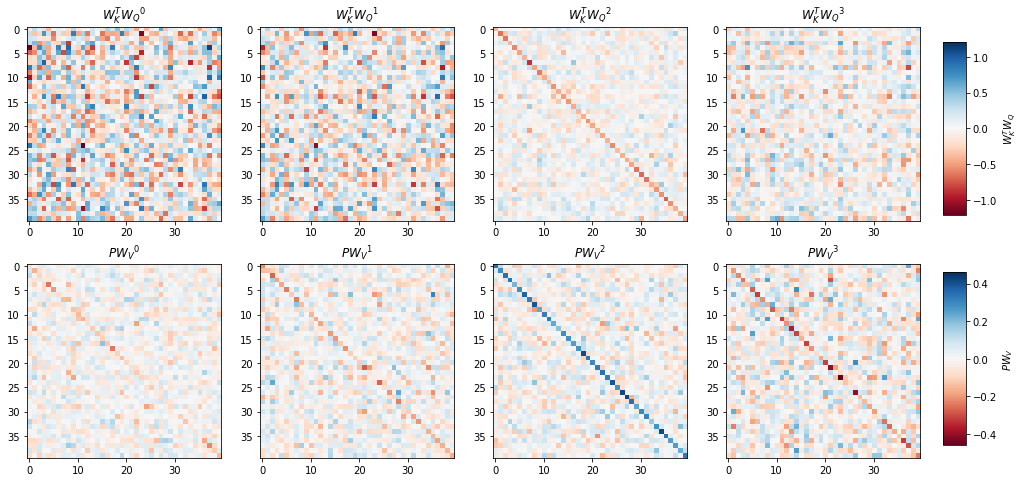

In [15]:
n_layers = 6
store_path = f'weights_deep_transformer.pdf'
visualize_weights(state=state_tf, 
                    layer_index=3, 
                    num_heads=4, 
                    key_size=20,
                    scale=1,
                    with_loss=False,
                    loss_level=0.1,
                    store=False,
                    store_path=store_path)

## Attention-Maps

In [33]:
exp_config_sensitivity = get_experiment_config(experiment='probing_full', seeds=[1, 11, 111, 1111, 11111])
(model, optimizer, data_generator, train_module) = TrainingInitializer(model_config=get_model_config(models_full['full_mesa']), 
                                                                       experiment_config=exp_config_sensitivity).run()
training_seed = 42
rng = jax.random.PRNGKey(training_seed)
rng, test_rng, train_rng = jax.random.split(rng, 3)
state_tf, rng = train_module.get_init_state(rng, interpol_call=False)
(test_data, _), _ = data_generator.get_data(rng=test_rng, batch_size=2048)

model:  fully_obs_full_fledged_mesa  layers: 1  heads:  4  embed_dim:  40  seq_len:  50  key_size:  20  pe_kq:  True  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  False  clip:  True  clip_val:  1


In [40]:
if rerun_models:
        for epoch_idx in range(200):
                state_tf, train_rng, _, _, _ = train_module.train_epoch(epoch=epoch_idx,
                                                                        state=state_tf,
                                                                        rng=train_rng,
                                                                        test_rng=test_rng,
                                                                        num_batches_train=100,
                                                                        interpolate=False)
# Alternatively: Load pre-trained Model
with open(path_model_fully_mesa, 'rb') as handle:
        a = pkl.load(handle)
state_tf = train_state.TrainState.create(apply_fn=model.apply, params=a['params'], tx=optimizer)
_, (_, attention_maps, _, _) = model.apply({'params': state_tf.params}, test_data)
att_map_array = jnp.array(attention_maps[0])

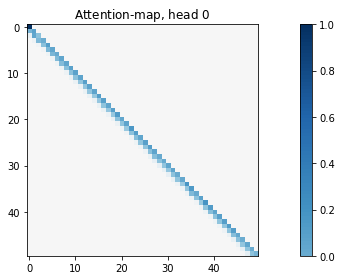

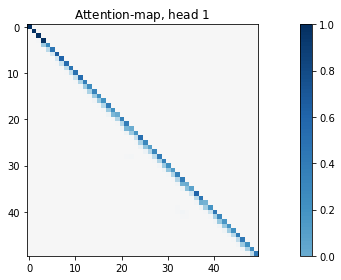

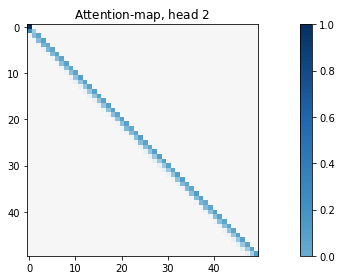

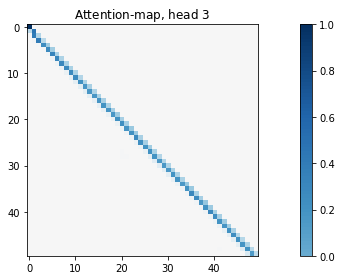

In [42]:
def one_head_attmap(arr, head, store):
    real_map = jnp.mean(arr[:,head],axis=(0))
    plt.figure(figsize=(12, 4))

    norm = TwoSlopeNorm(vcenter=0,vmax=1)

    plt.imshow(real_map, cmap='RdBu', norm=norm)
    plt.title(f"Attention-map, head ${head}$")
    plt.colorbar()
    if store:
        store_path = f'attention_map_{head}.pdf'
        plt.savefig(store_path, bbox_inches='tight', pad_inches=0.1)
    plt.tight_layout()
    plt.show()

for head in range(4):
    one_head_attmap(att_map_array, head=head, store=False)